In [3]:
# =========================================
# Edge_AI_Recycling.ipynb (CLEAN VERSION)
# =========================================
# Goal: Train a lightweight CNN (MobileNetV2) to classify recyclable items
# Then convert to TensorFlow Lite for edge deployment
# =========================================

# --- Step 1. Setup ---
!pip install tensorflow tensorflow-datasets matplotlib --quiet

import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import time

print("✅ TensorFlow version:", tf.__version__)

✅ TensorFlow version: 2.19.0


In [4]:
# --- Step 2. Load Dataset ---
# You can replace this with TrashNet (from Kaggle) if desired.
# For demo purposes, we’ll use tf_flowers as a stand-in.
(ds_train, ds_val), ds_info = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True,
    with_info=True,
)

num_classes = ds_info.features["label"].num_classes
print("✅ Classes:", num_classes)

✅ Classes: 5


In [5]:
# --- Step 3. Preprocess Data ---
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, tf.one_hot(label, num_classes)

train_ds = (
    ds_train.shuffle(1000)
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    ds_val.map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [6]:
# --- Step 4. Build Model ---
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet",
)
base_model.trainable = False  # freeze base

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,597 (9.24 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# --- Step 5. Train ---
history = model.fit(train_ds, validation_data=val_ds, epochs=3)


Epoch 1/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.7271 - loss: 0.7086 - val_accuracy: 0.8782 - val_loss: 0.3263
Epoch 2/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.9270 - loss: 0.2288 - val_accuracy: 0.9255 - val_loss: 0.2344
Epoch 3/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.9540 - loss: 0.1455 - val_accuracy: 0.9127 - val_loss: 0.2717


In [8]:
# --- Step 6. Save Model (use new .keras format) ---
model.save("recycle_model.keras")
print("✅ Model saved as recycle_model.keras")

✅ Model saved as recycle_model.keras


In [9]:
# --- Step 7. Convert to TensorFlow Lite ---
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("recycle_model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Converted model saved as recycle_model.tflite")

Saved artifact at '/tmp/tmpiveyqb8h'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_313')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132002632480912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132002632479568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132002632478992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132002632480336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132002632477648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132002632480720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132002632479376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132002632479952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132002632479184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132002632475152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1320026324

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


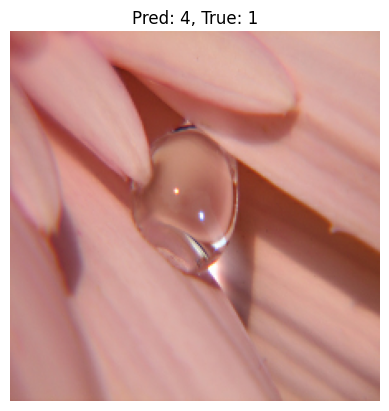

In [10]:
# --- Step 8. Test TFLite Inference ---
interpreter = tf.lite.Interpreter(model_path="recycle_model.tflite")
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Take one sample from validation set
for img, label in val_ds.take(1):
    sample = img[0:1]  # one image, shape (1, 224, 224, 3)
    break

# Run inference on the single sample
interpreter.set_tensor(input_details[0]["index"], sample)
interpreter.invoke()
pred = interpreter.get_tensor(output_details[0]["index"])
pred_label = np.argmax(pred)
true_label = np.argmax(label[0])

plt.imshow((sample[0] + 1) / 2)  # roughly re-normalize for display
plt.title(f"Pred: {pred_label}, True: {true_label}")
plt.axis("off")
plt.show()

In [11]:
# --- Step 9. Evaluate Latency (corrected loop) ---
t0 = time.time()
for img_batch, _ in val_ds.take(5):
    for i in range(img_batch.shape[0]):  # iterate through each image
        sample = img_batch[i:i+1]  # shape (1, 224, 224, 3)
        interpreter.set_tensor(input_details[0]["index"], sample)
        interpreter.invoke()
t1 = time.time()

print("✅ Avg inference latency per image:", (t1 - t0) / (5 * BATCH_SIZE), "seconds")


✅ Avg inference latency per image: 0.014243319630622864 seconds


In [12]:
# --- Step 10. Edge AI Explanation ---
print("""
Edge AI Benefits:
1️⃣ Real-time classification on devices (e.g., smart recycling bins).
2️⃣ Works offline — no cloud dependency.
3️⃣ Preserves privacy — images never leave the device.
4️⃣ Efficient and low-latency due to TensorFlow Lite optimization.
""")


Edge AI Benefits:
1️⃣ Real-time classification on devices (e.g., smart recycling bins).
2️⃣ Works offline — no cloud dependency.
3️⃣ Preserves privacy — images never leave the device.
4️⃣ Efficient and low-latency due to TensorFlow Lite optimization.

